In [543]:
import scipy
import numpy
import matplotlib
import pandas
import statsmodels
import sklearn
import fbprophet

from pandas import read_csv, read_excel, date_range, RangeIndex, DataFrame, to_datetime, Grouper, concat, DatetimeIndex
from pandas import to_numeric, DateOffset
from pandas.plotting import lag_plot, scatter_matrix, autocorrelation_plot
from datetime import datetime
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet

In [544]:
# Load data using read_excel
transactions_df = read_excel('Cuenta_124075.xlsx', sheet_name='_select_TRANSACTION_DATE_cast_a')

In [545]:
balance_last_day_real = to_numeric(transactions_df.loc[[0],['BALANCE']].squeeze(), downcast='float')

In [546]:
transactions_df = transactions_df.iloc[:,0:2]

In [547]:
# agregamos las transacciones por dia

In [548]:
transactions_df=transactions_df.groupby(transactions_df.TRANSACTION_DATE).sum()

In [549]:
transactions_df.reset_index(level=0, inplace=True)

In [550]:
range_of_dates = date_range(start=transactions_df.TRANSACTION_DATE.min(), end=transactions_df.TRANSACTION_DATE.max())

In [551]:
# rellenamos los dias sin transacciones con el valor 0.00

In [552]:
transactions_df = \
transactions_df.set_index('TRANSACTION_DATE').reindex(range_of_dates).fillna(0.0).rename_axis('TRANSACTION_DATE').reset_index()

In [553]:
transactions_df=transactions_df.set_index(transactions_df.iloc[:,0])

In [554]:
transactions_df=transactions_df.drop(['TRANSACTION_DATE'], axis = 1)

In [555]:
# construimos el dataframe del balance de la cuenta

In [556]:
balance_df=transactions_df.copy()

In [557]:
balance_df.reset_index(level=0, inplace=True)

In [558]:
balance_df["DATE"]=balance_df["TRANSACTION_DATE"]

In [559]:
balance_df["BALANCE"]=0

In [560]:
for i in range(balance_df.index[0],balance_df.index[-1]):
    balance_df.loc[i+1,'BALANCE'] = balance_df.loc[i,'BALANCE'] + \
    balance_df.loc[i,'AMOUNT']

In [561]:
balance_df=balance_df.drop(['TRANSACTION_DATE','AMOUNT'], axis = 1)

In [562]:
balance_df=balance_df.set_index(balance_df.iloc[:,0])

In [563]:
balance_df=balance_df.drop(['DATE'], axis = 1)

In [564]:
balance_last_day_fake = to_numeric(balance_df.iloc[-1:].squeeze(), downcast='float')

In [565]:
bias = balance_last_day_real - balance_last_day_fake

In [566]:
balance_df['BALANCE'] = balance_df['BALANCE'] + bias

In [567]:
# preparamos un dataframe prophet_df para entrenar un modelo

In [568]:
prophet_df = balance_df.copy()

In [569]:
prophet_df.reset_index(level=0, inplace=True)

In [570]:
# prepare expected column names
prophet_df.columns = ['ds', 'y']

In [571]:
prophet_df['ds'] = to_datetime(prophet_df['ds'])

In [572]:
# define the model
model = Prophet()
# fit the model
model.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [573]:
# HACEMOS UNA PREDICCION A 90 DIAS

In [574]:
# Make an Out-of-Sample Forecast

In [575]:
future_out_sample_df=prophet_df.copy()

In [576]:
future_out_sample_df=future_out_sample_df.drop(['y'], axis = 1)

In [577]:
future_out_sample_df=future_out_sample_df[-90:]

In [578]:
future_out_sample_df.reset_index(level=0, inplace=True)

In [579]:
future_out_sample_df=future_out_sample_df.drop(['index'], axis = 1)

In [580]:
future_out_sample_df.iloc[0,0]=future_out_sample_df.iloc[-1,0] + DateOffset(1)

In [581]:
for i in range(1,len(future_out_sample_df)):
    future_out_sample_df.iloc[i,0]=future_out_sample_df.iloc[i-1,0] + DateOffset(1)    

In [582]:
# use the model to make a forecast
forecast_df = model.predict(future_out_sample_df)

In [583]:
forecast_per_day_df = forecast_df.loc[:,['ds','yhat']]

In [584]:
forecast_per_day_df.columns = ['DATE','BALANCE']

In [585]:
# a continuacion voy a hacer un dataframe con la prediccion del balance medio semanal de la cuenta a 90 dias

In [586]:
forecast_per_week_df=forecast_per_day_df.copy()

In [587]:
# Using a lambda function on apply.() to separate the year, month, day components

In [588]:
forecast_per_week_df['DATE'].apply(lambda forecast_per_week_df: datetime(year=forecast_per_week_df.year, \
                                                                         month=forecast_per_week_df.month, \
                                                                         day=forecast_per_week_df.day))

0    2021-02-10
1    2021-02-11
2    2021-02-12
3    2021-02-13
4    2021-02-14
        ...    
85   2021-05-06
86   2021-05-07
87   2021-05-08
88   2021-05-09
89   2021-05-10
Name: DATE, Length: 90, dtype: datetime64[ns]

In [589]:
# Set the date as the index

In [590]:
# convert the column (if it's a string) to datetime type
datetime_ser = to_datetime(forecast_per_week_df['DATE'])

In [591]:
# create datetime index passing the datetime series
datetime_index = DatetimeIndex(datetime_ser.values)

In [592]:
forecast_per_week_df=forecast_per_week_df.set_index(datetime_index)

In [593]:
# we don't need the column DATE anymore
forecast_per_week_df.drop('DATE', axis=1, inplace=True)

In [594]:
# Using resample() method to aggregate by weeks and add mean() to take the average

In [595]:
forecast_per_week_ser = forecast_per_week_df['BALANCE'].resample('W').mean()

In [599]:
# guardamos el resultado final en un fichero .csv

In [600]:
forecast_per_week_ser.to_csv(path_or_buf='forecast_per_week.csv')

In [601]:
# el script acabaría aqui y el siguiente paso es probar otro script donde se ejecute todo en una misma celda y por ultimo
# grabarlo como un .ipynb y como un .py para ya debugearlo en pycharm en windows y en linux con su entorno hasta tenerlo todo
# terminado y funcionando

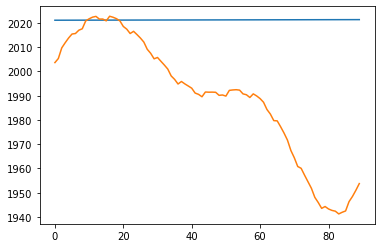

In [477]:
pyplot.plot(forecast_per_day_df)
pyplot.show()

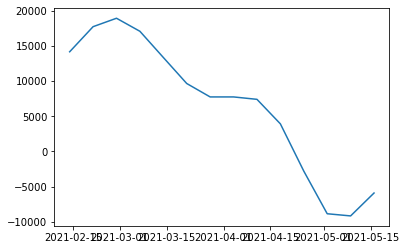

In [476]:
pyplot.plot(forecast_per_week_df)
pyplot.show()

In [464]:
datetime_index

DatetimeIndex(['2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2021-03-06', '2021-03-07', '2021-03-08', '2021-03-09',
               '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13',
               '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
               '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21',
               '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
               '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29',
               '2021-03-30', '2021-03-31', '2021-04-01', '2021-04-02',
               '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06',
      

In [461]:
datetime_ser

0    2021-02-10
1    2021-02-11
2    2021-02-12
3    2021-02-13
4    2021-02-14
        ...    
85   2021-05-06
86   2021-05-07
87   2021-05-08
88   2021-05-09
89   2021-05-10
Name: DATE, Length: 90, dtype: datetime64[ns]

In [598]:
forecast_per_week_ser

2021-02-14    14192.072542
2021-02-21    17766.959213
2021-02-28    18968.671858
2021-03-07    17110.340628
2021-03-14    13382.246019
2021-03-21     9672.042658
2021-03-28     7760.011270
2021-04-04     7760.273524
2021-04-11     7416.942256
2021-04-18     3922.865319
2021-04-25    -2809.050323
2021-05-02    -8879.868581
2021-05-09    -9189.386921
2021-05-16    -5926.503716
Freq: W-SUN, Name: BALANCE, dtype: float64

In [596]:
forecast_per_week_df

,BALANCE
2021-02-10,12289.183748
2021-02-11,12900.885477
2021-02-12,14503.528761
2021-02-13,15275.060359
2021-02-14,15991.704366
...,...
2021-05-06,-10045.794758
2021-05-07,-8647.722828
2021-05-08,-7871.022681
2021-05-09,-6940.728323


In [475]:
forecast_per_week_df.shape

(14,)

In [474]:
forecast_per_week_df.dtypes

dtype('float64')

In [471]:
forecast_per_week_df.index

DatetimeIndex(['2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2021-03-06', '2021-03-07', '2021-03-08', '2021-03-09',
               '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13',
               '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
               '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21',
               '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
               '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29',
               '2021-03-30', '2021-03-31', '2021-04-01', '2021-04-02',
               '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06',
      

In [446]:
forecast_per_day_df

,DATE,BALANCE
0,2021-02-10,12289.183748
1,2021-02-11,12900.885477
2,2021-02-12,14503.528761
3,2021-02-13,15275.060359
4,2021-02-14,15991.704366
...,...,...
85,2021-05-06,-10045.794758
86,2021-05-07,-8647.722828
87,2021-05-08,-7871.022681
88,2021-05-09,-6940.728323


In [424]:
future_in_out_sample_df=future_in_sample_df.copy()

In [431]:
future_in_out_sample_df=future_in_out_sample_df.append(future_out_sample_df)

In [433]:
future_in_out_sample_df.reset_index(level=0, inplace=True)

In [435]:
future_in_out_sample_df=future_in_out_sample_df.drop(['index'], axis = 1)

In [437]:
# use the model to make a forecast
forecast_in_out_sample_df = model.predict(future_in_out_sample_df)

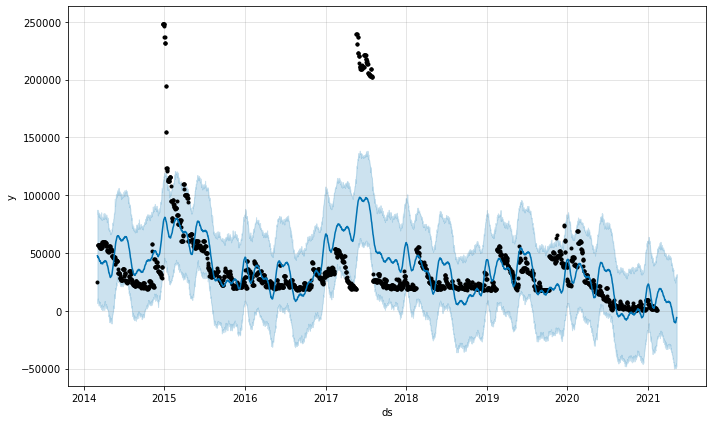

In [438]:
# plot forecast
model.plot(forecast_in_out_sample_df)
pyplot.show()

In [436]:
future_in_out_sample_df

,ds
0,2014-03-03
1,2014-03-04
2,2014-03-05
3,2014-03-06
4,2014-03-07
...,...
2621,2021-05-06
2622,2021-05-07
2623,2021-05-08
2624,2021-05-09


In [440]:
forecast_in_out_sample_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2014-03-03,47604.742696,6575.624015,87476.580622
1,2014-03-04,46843.721980,10632.100871,83832.488457
2,2014-03-05,46530.989843,8829.593458,85592.995156
3,2014-03-06,45965.004422,6943.788304,86619.450748
4,2014-03-07,46398.603801,8897.609025,81617.358910
...,...,...,...,...
2621,2021-05-06,-10045.794758,-49696.075753,29193.097140
2622,2021-05-07,-8647.722828,-45657.929698,30683.603520
2623,2021-05-08,-7871.022681,-48561.234376,28794.090504
2624,2021-05-09,-6940.728323,-47182.505650,29872.209482


In [410]:
future_out_sample_df

,ds
0,2021-02-10
1,2021-02-11
2,2021-02-12
3,2021-02-13
4,2021-02-14
...,...
85,2021-05-06
86,2021-05-07
87,2021-05-08
88,2021-05-09


In [411]:
future_out_sample_df.dtypes

ds    datetime64[ns]
dtype: object

In [421]:
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-10,4370.920982,-25915.528464,50213.218646,4370.920982,4370.920982,7918.262766,7918.262766,7918.262766,-288.577537,-288.577537,-288.577537,8206.840304,8206.840304,8206.840304,0.0,0.0,0.0,12289.183748
1,2021-02-11,4311.816516,-25960.222552,52011.775155,4311.816516,4311.816516,8589.068961,8589.068961,8589.068961,-524.549801,-524.549801,-524.549801,9113.618763,9113.618763,9113.618763,0.0,0.0,0.0,12900.885477
2,2021-02-12,4252.712051,-22638.674005,54184.761890,4252.712051,4252.712051,10250.816710,10250.816710,10250.816710,270.434389,270.434389,270.434389,9980.382321,9980.382321,9980.382321,0.0,0.0,0.0,14503.528761
3,2021-02-13,4193.607585,-22205.465369,53409.831639,4193.607585,4193.607585,11081.452774,11081.452774,11081.452774,281.516297,281.516297,281.516297,10799.936477,10799.936477,10799.936477,0.0,0.0,0.0,15275.060359
4,2021-02-14,4134.503119,-22010.483348,51581.079090,4134.503119,4134.503119,11857.201247,11857.201247,11857.201247,291.086248,291.086248,291.086248,11566.114999,11566.114999,11566.114999,0.0,0.0,0.0,15991.704366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-05-06,-652.958590,-46574.720681,25579.930303,-3468.394917,1677.218377,-9392.836168,-9392.836168,-9392.836168,-524.549801,-524.549801,-524.549801,-8868.286367,-8868.286367,-8868.286367,0.0,0.0,0.0,-10045.794758
86,2021-05-07,-712.063056,-46733.911765,30692.320061,-3597.300477,1647.198142,-7935.659773,-7935.659773,-7935.659773,270.434389,270.434389,270.434389,-8206.094162,-8206.094162,-8206.094162,0.0,0.0,0.0,-8647.722828
87,2021-05-08,-771.167521,-48543.740171,29949.042770,-3705.632491,1613.013495,-7099.855160,-7099.855160,-7099.855160,281.516297,281.516297,281.516297,-7381.371457,-7381.371457,-7381.371457,0.0,0.0,0.0,-7871.022681
88,2021-05-09,-830.271987,-45584.871134,31374.809690,-3831.117205,1578.828847,-6110.456336,-6110.456336,-6110.456336,291.086248,291.086248,291.086248,-6401.542584,-6401.542584,-6401.542584,0.0,0.0,0.0,-6940.728323


In [422]:
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2021-02-10,12289.183748,-25915.528464,50213.218646
1,2021-02-11,12900.885477,-25960.222552,52011.775155
2,2021-02-12,14503.528761,-22638.674005,54184.761890
3,2021-02-13,15275.060359,-22205.465369,53409.831639
4,2021-02-14,15991.704366,-22010.483348,51581.079090
...,...,...,...,...
85,2021-05-06,-10045.794758,-46574.720681,25579.930303
86,2021-05-07,-8647.722828,-46733.911765,30692.320061
87,2021-05-08,-7871.022681,-48543.740171,29949.042770
88,2021-05-09,-6940.728323,-45584.871134,31374.809690


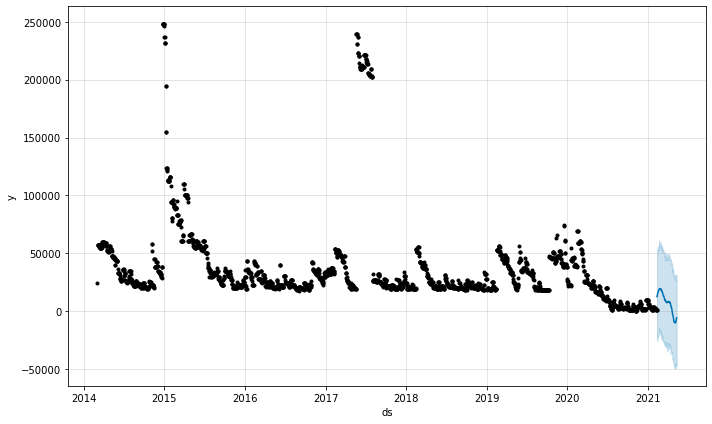

In [423]:
# plot forecast
model.plot(forecast_df)
pyplot.show()

In [362]:
prophet_df

,ds,y
0,2014-03-03,24493.44
1,2014-03-04,56790.85
2,2014-03-05,56720.85
3,2014-03-06,56699.85
4,2014-03-07,56699.85
...,...,...
2531,2021-02-05,1407.45
2532,2021-02-06,956.59
2533,2021-02-07,956.59
2534,2021-02-08,956.59


In [363]:
prophet_df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [364]:
balance_df

,BALANCE
DATE,
2014-03-03,24493.44
2014-03-04,56790.85
2014-03-05,56720.85
2014-03-06,56699.85
2014-03-07,56699.85
...,...
2021-02-05,1407.45
2021-02-06,956.59
2021-02-07,956.59


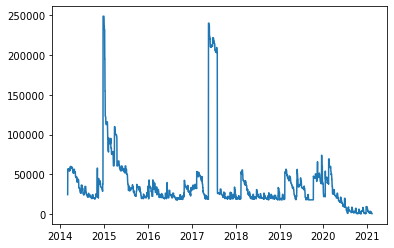

In [365]:
pyplot.plot(balance_df)
pyplot.show()

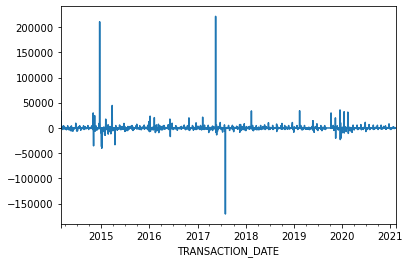

In [366]:
transactions_ser=transactions_df.squeeze()
transactions_ser.plot()
pyplot.show()

In [367]:
transactions_df

,AMOUNT
TRANSACTION_DATE,
2014-03-03,32297.41
2014-03-04,-70.00
2014-03-05,-21.00
2014-03-06,0.00
2014-03-07,-40.00
...,...
2021-02-05,-450.86
2021-02-06,0.00
2021-02-07,0.00


In [368]:
transactions_ser

TRANSACTION_DATE
2014-03-03    32297.41
2014-03-04      -70.00
2014-03-05      -21.00
2014-03-06        0.00
2014-03-07      -40.00
                ...   
2021-02-05     -450.86
2021-02-06        0.00
2021-02-07        0.00
2021-02-08     -306.00
2021-02-09     -237.80
Name: AMOUNT, Length: 2536, dtype: float64

In [369]:
range_of_dates

DatetimeIndex(['2014-03-03', '2014-03-04', '2014-03-05', '2014-03-06',
               '2014-03-07', '2014-03-08', '2014-03-09', '2014-03-10',
               '2014-03-11', '2014-03-12',
               ...
               '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03',
               '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07',
               '2021-02-08', '2021-02-09'],
              dtype='datetime64[ns]', length=2536, freq='D')

In [370]:
balance_last_day_real, type(balance_last_day_real)

(650.59, numpy.float64)

In [371]:
balance_last_day_fake, type(balance_last_day_fake)

(-23842.84999999994, numpy.float64)

In [372]:
bias, type(bias)

(24493.43999999994, numpy.float64)

In [373]:
# check the versions of key python libraries

# scipy
# import scipy
print('scipy: %s' % scipy.__version__)

# numpy
# import numpy
print('numpy: %s' % numpy.__version__)

# matplotlib
# import matplotlib
print('matplotlib: %s' % matplotlib.__version__)

# pandas
# import pandas
print('pandas: %s' % pandas.__version__)

# statsmodels
# import statsmodels
print('statsmodels: %s' % statsmodels.__version__)

# scikit-learn
# import sklearn
print('sklearn: %s' % sklearn.__version__)

# import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

scipy: 1.6.1
numpy: 1.19.2
matplotlib: 3.3.4
pandas: 1.2.2
statsmodels: 0.12.2
sklearn: 0.23.2
Prophet 0.7.1


In [412]:
future_in_sample_df=prophet_df.copy()

In [413]:
future_in_sample_df=future_in_sample_df.drop(['y'], axis = 1)

In [414]:
# use the model to make a forecast
forecast_in_sample_df = model.predict(future_in_sample_df)

In [415]:
future_in_sample_df

,ds
0,2014-03-03
1,2014-03-04
2,2014-03-05
3,2014-03-06
4,2014-03-07
...,...
2531,2021-02-05
2532,2021-02-06
2533,2021-02-07
2534,2021-02-08


In [416]:
future_in_sample_df.dtypes

ds    datetime64[ns]
dtype: object

In [417]:
forecast_in_sample_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-03-03,32794.146683,8220.311376,84075.899899,32794.146683,32794.146683,14810.596014,14810.596014,14810.596014,239.446957,239.446957,239.446957,14571.149057,14571.149057,14571.149057,0.0,0.0,0.0,47604.742696
1,2014-03-04,32897.835987,10642.891848,84125.787230,32897.835987,32897.835987,13945.885993,13945.885993,13945.885993,-269.356552,-269.356552,-269.356552,14215.242545,14215.242545,14215.242545,0.0,0.0,0.0,46843.721980
2,2014-03-05,33001.525292,5586.420348,83546.621523,33001.525292,33001.525292,13529.464552,13529.464552,13529.464552,-288.577537,-288.577537,-288.577537,13818.042089,13818.042089,13818.042089,0.0,0.0,0.0,46530.989843
3,2014-03-06,33105.214596,5638.461604,85137.396837,33105.214596,33105.214596,12859.789826,12859.789826,12859.789826,-524.549801,-524.549801,-524.549801,13384.339628,13384.339628,13384.339628,0.0,0.0,0.0,45965.004422
4,2014-03-07,33208.903900,6794.888465,82768.454990,33208.903900,33208.903900,13189.699901,13189.699901,13189.699901,270.434389,270.434389,270.434389,12919.265512,12919.265512,12919.265512,0.0,0.0,0.0,46398.603801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2531,2021-02-05,4666.443309,-30497.420719,48981.843947,4666.443309,4666.443309,3664.704373,3664.704373,3664.704373,270.434389,270.434389,270.434389,3394.269984,3394.269984,3394.269984,0.0,0.0,0.0,8331.147682
2532,2021-02-06,4607.338844,-29726.634314,47710.603978,4607.338844,4607.338844,4640.217178,4640.217178,4640.217178,281.516297,281.516297,281.516297,4358.700881,4358.700881,4358.700881,0.0,0.0,0.0,9247.556022
2533,2021-02-07,4548.234378,-27640.405720,52261.888694,4548.234378,4548.234378,5624.675393,5624.675393,5624.675393,291.086248,291.086248,291.086248,5333.589144,5333.589144,5333.589144,0.0,0.0,0.0,10172.909771
2534,2021-02-08,4489.129913,-30992.291679,48742.427968,4489.129913,4489.129913,6546.573705,6546.573705,6546.573705,239.446957,239.446957,239.446957,6307.126748,6307.126748,6307.126748,0.0,0.0,0.0,11035.703618


In [418]:
forecast_in_sample_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2014-03-03,47604.742696,8220.311376,84075.899899
1,2014-03-04,46843.721980,10642.891848,84125.787230
2,2014-03-05,46530.989843,5586.420348,83546.621523
3,2014-03-06,45965.004422,5638.461604,85137.396837
4,2014-03-07,46398.603801,6794.888465,82768.454990
...,...,...,...,...
2531,2021-02-05,8331.147682,-30497.420719,48981.843947
2532,2021-02-06,9247.556022,-29726.634314,47710.603978
2533,2021-02-07,10172.909771,-27640.405720,52261.888694
2534,2021-02-08,11035.703618,-30992.291679,48742.427968


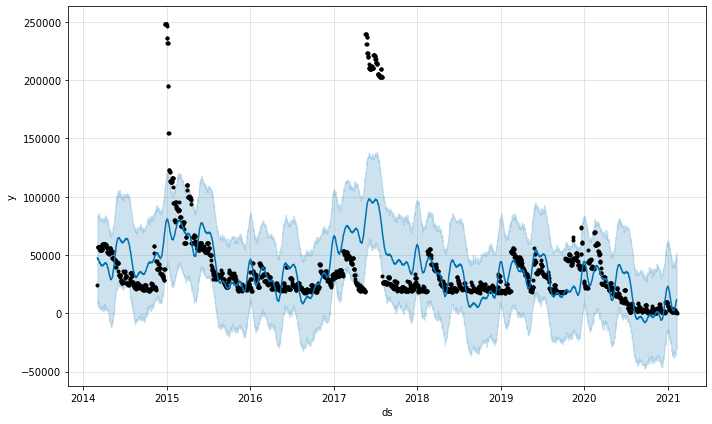

In [419]:
# plot forecast
model.plot(forecast_in_sample_df)
pyplot.show()